# **Temperature Forecasting Using Univariate LSTM**

- **Author**: Peyman Khodabandehlouei
- **Date**: June 19, 2025
- **Task**: Build a deep learning model to forecast future temperatures based on historical weather data using LSTM
- **Dataset:** [Last 10 year Istanbul weather data](https://github.com/PeymanKh/weather_forecasting_lstm)

This project implements a sequence modeling approach using Long Short Term Memory (LSTM) to capture temporal patterns in daily weather data. The model is trained to predict the next day's maximum temperature.

## Setup & Imports

In [59]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [7]:
# List available physical devices (GPU or CPU)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU:", gpus)
else:
    print("Using CPU.")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Set random seed
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print(f"Random seeds set to {seed}.")

set_seed(42)

Random seeds set to 42.


## Data Prepration

This dataset has been collected using Meteostat open-source API and already cleaned and is ready for model training. For more information about data gathering and data preprocessing you can visit [this GitHub](https://github.com/PeymanKh/weather_forecasting_lstm) repo.

In [9]:
# Load the csv from google drive
weather_df = pd.read_csv('/content/cleaned_weather_data.csv')
weather_df.head()

,date,avg_temp,min_temp,max_temp,wind_speed
0,2015-06-22,20.6,18.3,22.9,25.9
1,2015-06-23,21.8,19.0,25.0,20.2
2,2015-06-24,21.8,19.0,25.8,10.2
3,2015-06-25,21.9,17.0,26.1,11.9
4,2015-06-26,22.3,19.5,26.0,11.1


In [10]:
# Print df information
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        3650 non-null   object 
 1   avg_temp    3650 non-null   float64
 2   min_temp    3650 non-null   float64
 3   max_temp    3650 non-null   float64
 4   wind_speed  3650 non-null   float64
dtypes: float64(4), object(1)
memory usage: 142.7+ KB


In [11]:
# Find missing values
weather_df.isnull().sum()

,0
date,0
avg_temp,0
min_temp,0
max_temp,0
wind_speed,0


This model forecasts the next day's maximum temperature so `max_temp` is prepared as the target variable for training the model. To capture temporal dependencies in the data, time-series sequences are constructed using sliding windows of **14**, **30**, and **60** days. These correspond to:
- 14 days: past two weeks data
- 30 days: past one month data
- 60 days: past two months data

Each window size will be tested during training to evaluate which captures the underlying patterns most effectively and yields the best forecasting performance for the next day's maximum temperature.

In [12]:
def split_sequence(sequence, n_step):
  """
  Function to split the sequence into training and testing sequqnces with desired step size ready for feeding the model.

  Args:
    - sequence (np.array): Array of target sequence.
    - n_step: (int): step size for spliting the sequence.

  Returns:
    - X (np.array): 3D input for LSTM model [samples, timesteps, features]
    - y (np.array): Corresponding target values

  """

  X, y = list(), list()

  for i in range(len(sequence)):
    # Find end of the pattern
    end_index = i + n_step

    # Check if we are beyond the sequence
    if end_index > len(sequence)-1:
      break

    # Gather X and y parts
    seq_x, seq_y = sequence[i:end_index], sequence[end_index]

    X.append(seq_x)
    y.append(seq_y)

  # Convert lists to np.array
  X = np.array(X)
  y= np.array(y)

  # Reshape input to include 3rd dimension as LSTM requires ([samples, timesteps, features]).
  # right now it only have 2 dimensions. ([samples, timesteps])
  X = X.reshape(X.shape[0], X.shape[1], 1)

  return X, y

In [13]:
# select target variable and convert it to numpy array using .values
training_set = weather_df.iloc[:, 3:4].values
training_set

array([[22.9],
       [25. ],
       [25.8],
       ...,
       [26. ],
       [27. ],
       [30.1]])

In [14]:
# Scaling training set so values will be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_training_set = scaler.fit_transform(training_set)

In [15]:
scaled_training_set

array([[0.617866  ],
       [0.66997519],
       [0.6898263 ],
       ...,
       [0.69478908],
       [0.71960298],
       [0.79652605]])

In [16]:
# Create different sequences of data
n_steps = [14, 30, 60]
sequences = {}

for n in n_steps:
  X, y = split_sequence(scaled_training_set, n)
  sequences[n] = {'X': X, 'y': y}

Since the data is continuous sequence in forecasting, we can not use use shuffling for spliting the data into `training set`, `validation set`, and `testing set`. Instead, we should consider first part of the data as training set, next part as validation set, and last part as testing set.

|<--- train --->|<-- val -->|<-- test -->|

|---- 80% -----|--- 10% ---|--- 10% ----|


In [17]:
def time_series_split(X, y, train_ratio=0.8, val_ratio=0.1):
    """
    Splits time series data into train, validation, and test sets in a sequential manner.

    This function avoids shuffling to maintain the temporal order, which is essential
    for time series forecasting. It returns a dictionary containing the splits.

    Args:
        - X (np.array): Input features of shape [samples, timesteps, features]
        - y (np.array): Corresponding target values
        - train_ratio (float): Proportion of data to allocate to training (default: 0.8)
        - val_ratio (float): Proportion of data to allocate to validation (default: 0.1)

    Returns:
        - dict: A dictionary with the following keys:
            - 'X_train', 'y_train': Training set
            - 'X_val', 'y_val': Validation set
            - 'X_test', 'y_test': Test set (remaining data)
    """

    # Calculate split indices
    total = len(X)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    # Return the splits in a dictionary
    return {
        'X_train': X[:train_end],
        'y_train': y[:train_end],
        'X_val': X[train_end:val_end],
        'y_val': y[train_end:val_end],
        'X_test': X[val_end:],
        'y_test': y[val_end:]
    }

In [18]:
splits = {}

for n in sequences:
    X, y = sequences[n]['X'], sequences[n]['y']
    splits[n] = time_series_split(X, y)

## Model Training
This model has 3 LSTM layers with Dropout 20% for regularization.

In [46]:
def build_model(input_shape, unites=64, dropout_rate=0.2):
  """
  Builds and compiles a simple LSTM model for time series forecasting.

  Args:
    - input_shape (tuple): Shape of input data (timesteps, features)
    - units (int): Number of LSTM units
    - dropout_rate (float): Dropout rate after LSTM layer

  Returns:
    - model (tf.keras.Model): Compiled LSTM model
    """

  model = Sequential()

  model.add(LSTM(unites, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(dropout_rate))

  model.add(LSTM(unites, return_sequences=True))
  model.add(Dropout(dropout_rate))

  model.add(LSTM(unites, return_sequences=False))
  model.add(Dropout(dropout_rate))

  # Output layer
  model.add(Dense(1))

  # Compile the model
  model.compile('adam', loss='mse')

  return model

In [47]:
# Train the model with different n_steps

histories = {}
models = {}

for n_step in splits.keys():
  print(f"\nTraining model with n_step = {n_step}...\n")

  # Get data splits
  data = splits[n_step]

  X_train, y_train = data['X_train'], data['y_train']
  X_val, y_val = data['X_val'], data['y_val']
  X_test, y_test = data['X_test'], data['y_test']

  # Build model
  model = build_model(X_train.shape[1:])

  # Add early stopping
  early_stop = EarlyStopping(
      monitor='val_loss',
      patience=5,
      restore_best_weights=True
      )

  # Train the model
  history = model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs=100,
      batch_size=32,
      verbose=1,
      callbacks=[early_stop]
      )

  models[n_step] = model
  histories[n_step] = history


Training model with n_step = 14...

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0611 - val_loss: 0.0080
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - val_loss: 0.0079
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0102 - val_loss: 0.0094
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - val_loss: 0.0104
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0073
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 10/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 11/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.0065
Epoch 12/100
91/91 ━━━━━━

# Model Evaluation
To evalute performance of the model, MAE, RMSE, and R2 metrices are tested for each model.

In [60]:
results = {}

for n_step, model in models.items():
  X_test = splits[n_step]['X_test']
  y_test = splits[n_step]['y_test']

  # Predict and inverse transform
  y_hat = model.predict(X_test)
  y_true = scaler.inverse_transform(y_test.reshape(-1, 1))
  y_hat = scaler.inverse_transform(y_hat)

  # Calculate metrics
  mae = mean_absolute_error(y_true, y_hat)
  rmse = np.sqrt(mean_squared_error(y_true, y_hat))
  r2 = r2_score(y_true, y_hat)

  results[n_step] = {
      'MAE': mae,
      'RMSE': rmse,
      'R2': r2
      }

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [61]:
results_df = pd.DataFrame(results).T.sort_index()
results_df

,MAE,RMSE,R2
14,1.815954,2.390552,0.918543
30,1.813839,2.392512,0.918000
60,1.788345,2.361511,0.919976


In [67]:
# Saving the model
model.save(f"final_model.h5")
import joblib
joblib.dump(scaler, "scaler.save")

['scaler.save']

As evaluation metrices show, the best performing model has n_step 60. MAE shows that its predictions can be off by 1.78°C, RMSE shows that average error can grow up to 2.362°C when big mistakes happen, and finally R2 score indicates that this model captures 91% variation in dataset. You can find visualizations of this model below.

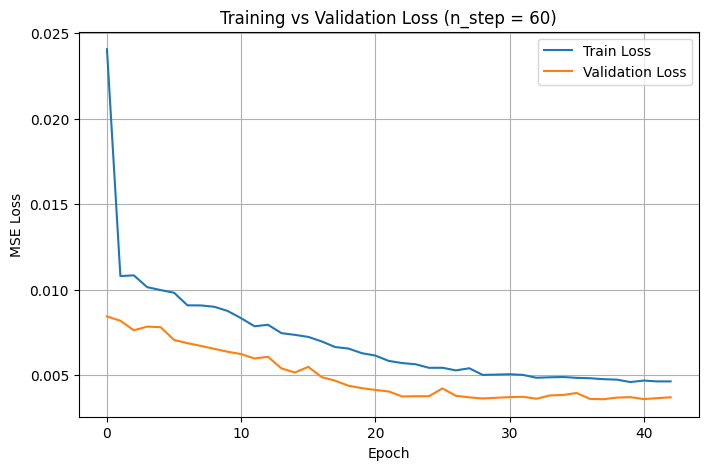

In [63]:
# Training vs. validation loss curve
plt.figure(figsize=(8, 5))
plt.plot(histories[60].history['loss'], label='Train Loss')
plt.plot(histories[60].history['val_loss'], label='Validation Loss')
plt.title(f'Training vs Validation Loss (n_step = {n_step})')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


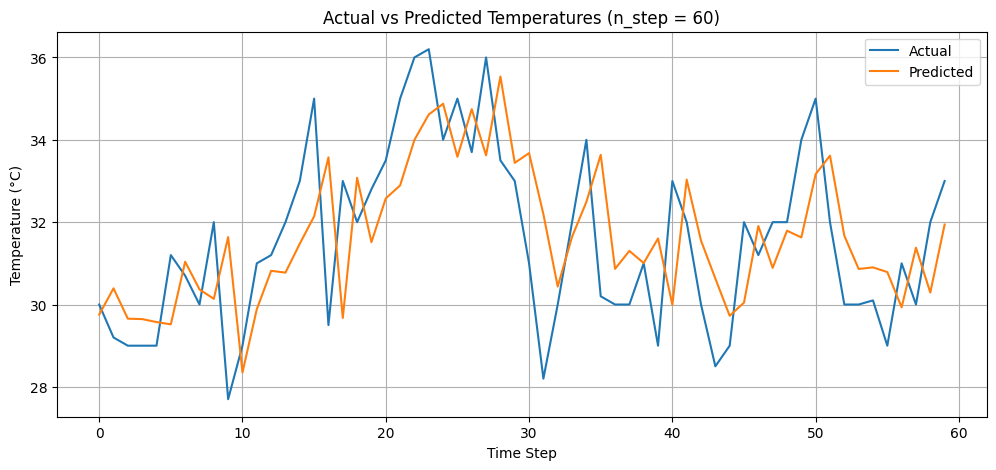

In [65]:
# Actual vs. predicted

X_test = splits[60]['X_test']
y_test = splits[60]['y_test']

# Predict and inverse transform
y_hat = model.predict(X_test)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_hat = scaler.inverse_transform(y_hat)

plt.figure(figsize=(12, 5))
plt.plot(y_true[:n], label='Actual')
plt.plot(y_pred[:n], label='Predicted')
plt.title(f'Actual vs Predicted Temperatures (n_step = 60)')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


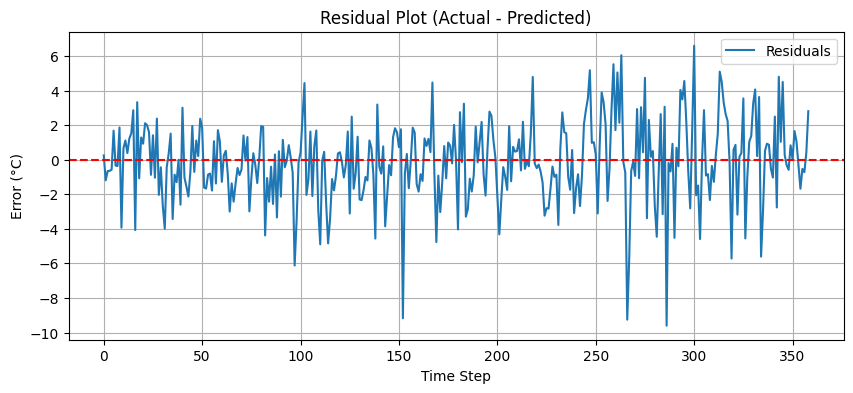

In [66]:
# Reseduals
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label='Residuals')
    plt.title('Residual Plot (Actual - Predicted)')
    plt.xlabel('Time Step')
    plt.ylabel('Error (°C)')
    plt.axhline(0, color='red', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_residuals(y_true, y_pred)

## Conclusion

In this project, I built an LSTM-based time series forecasting model to predict future temperatures using historical weather data. After experimenting with different sequence lengths (`n_step`), I trained and evaluated multiple models, selecting the best one based on validation performance and error analysis.

### Key Findings

- The best-performing model used `n_step = 60`, achieving:
  - **Low training and validation loss** (MSE ≈ 0.0046 and 0.0037 respectively)
  - **No signs of overfitting**, confirmed by smooth loss curves and close train/val performance
- Residual analysis showed:
  - **Residuals centered around 0**, indicating no prediction bias
  - **Most errors within ±5°C**, which is acceptable for temperature forecasting
  - A few outliers, likely due to extreme or sudden weather changes

### Visual Evaluation

- Loss curves confirmed stable training and proper generalization
- Prediction vs. actual plots showed that the model closely follows real temperature trends
- Residual and error distribution plots validated consistent performance and limited variance

### Overall Evaluation

The LSTM model demonstrates strong forecasting ability and generalizes well on unseen data. The current setup is a robust baseline, and future improvements could include:

- Incorporating additional weather features (e.g., wind, humidity, pressure)
- Extending to **multi-step forecasting** (predict multiple days ahead)
- Testing alternative architectures such as **GRU**, **Bidirectional LSTM**, or **Attention-based LSTM**

This project successfully achieves its objective of building a reliable deep learning model for temperature forecasting and provides a solid foundation for further development and real-world deployment.
